## Load the Datasets

In [28]:
import pandas as pd

# Load datasets
fraud_data = pd.read_csv('../data/Fraud_Data.csv')
ip_data = pd.read_csv('../data/IpAddress_to_Country.csv')
# creditcard_data = pd.read_csv('creditcard.csv')

## Data Exploration

In [29]:
# Check the data types and missing values
print(fraud_data.info())
print(fraud_data.describe())

print(ip_data.info())
print(ip_data.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None
             user_id  purchase_value            age    ip_address  \
count  151112.000000   151112.000000  151112.000000  1.511120e+05   
mean   200171.040970       36.935372      33.140704  2.152145e+09   
std    115369.28

## Handle Missing Values

In [30]:
# Impute or drop missing values as needed
fraud_data.fillna({
    'sex': 'Unknown',
    'age': fraud_data['age'].mean(),
    'source': 'Unknown',
    'browser': 'Unknown'
}, inplace=True)

# Check for missing values
print(fraud_data.isnull().sum())

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64


## Data Cleaning

In [31]:
# Remove duplicates
fraud_data.drop_duplicates(inplace=True)

# Convert timestamps to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])



## Geolocation Analysis

In [32]:

# Merge with country data
merged_data = pd.merge(fraud_data, ip_data, how='left', left_on='ip_address', right_on='lower_bound_ip_address')

# Check the merged data
print(merged_data.head())

   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0   

   lower_bound_ip_address  upper_bound_ip_address country  
0                     NaN                     NaN     NaN  
1                     NaN                     NaN     NaN  
2       

## Feature Engineering

In [33]:
# Extract time-based features
merged_data['hour_of_day'] = merged_data['purchase_time'].dt.hour
merged_data['day_of_week'] = merged_data['purchase_time'].dt.dayofweek

# Calculate transaction frequency and velocity
transaction_counts = merged_data.groupby('user_id')['purchase_value'].count().reset_index(name='transaction_count')
transaction_values = merged_data.groupby('user_id')['purchase_value'].sum().reset_index(name='total_spent')

merged_data = merged_data.merge(transaction_counts, on='user_id', how='left')
merged_data = merged_data.merge(transaction_values, on='user_id', how='left')

## Normalization and Scaling

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
merged_data[['purchase_value', 'transaction_count', 'total_spent']] = scaler.fit_transform(
    merged_data[['purchase_value', 'transaction_count', 'total_spent']]
)

## Encode Categorical Features

In [35]:
merged_data = pd.get_dummies(merged_data, columns=['source', 'browser', 'sex', 'country'], drop_first=True)

## Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
Index: 150045 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         150045 non-null  int64         
 1   signup_time     150045 non-null  datetime64[ns]
 2   purchase_time   150045 non-null  datetime64[ns]
 3   purchase_value  150045 non-null  int64         
 4   device_id       150045 non-null  object        
 5   source          150045 non-null  object        
 6   browser         150045 non-null  object        
 7   sex             150045 non-null  object        
 8   age             150045 non-null  int64         
 9   ip_address      150045 non-null  float64       
 10  class           150045 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 13.7+ MB
None


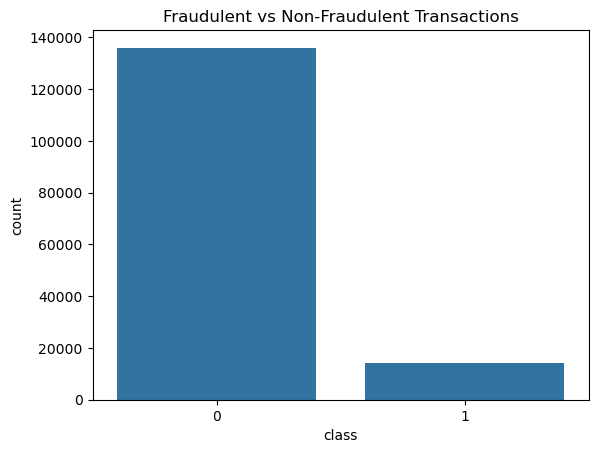

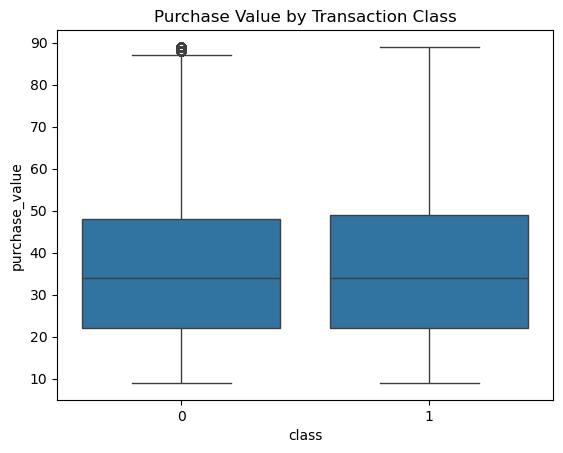

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate Q1 (25th percentile) and Q3 (75th percentile) for purchase_value
Q1_purchase = merged_data['purchase_value'].quantile(0.25)
Q3_purchase = merged_data['purchase_value'].quantile(0.75)
IQR_purchase = Q3_purchase - Q1_purchase

# Define bounds for purchase_value outliers
lower_bound_purchase = Q1_purchase - 1.5 * IQR_purchase
upper_bound_purchase = Q3_purchase + 1.5 * IQR_purchase

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for transaction_count
Q1_transaction = merged_data['transaction_count'].quantile(0.25)
Q3_transaction = merged_data['transaction_count'].quantile(0.75)
IQR_transaction = Q3_transaction - Q1_transaction

# Define bounds for transaction_count outliers
lower_bound_transaction = Q1_transaction - 1.5 * IQR_transaction
upper_bound_transaction = Q3_transaction + 1.5 * IQR_transaction

# Remove outliers for both purchase_value and transaction_count
fraud_data_cleaned = fraud_data[
    (merged_data['purchase_value'] >= lower_bound_purchase) & 
    (merged_data['purchase_value'] <= upper_bound_purchase) &
    (merged_data['transaction_count'] >= lower_bound_transaction) & 
    (merged_data['transaction_count'] <= upper_bound_transaction)
]

# Display the cleaned DataFrame
print(fraud_data_cleaned.info())

# Univariate Analysis
sns.countplot(data=fraud_data_cleaned, x='class')
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.show()

# Bivariate Analysis
sns.boxplot(data=fraud_data_cleaned, x='class', y='purchase_value')
plt.title('Purchase Value by Transaction Class')
plt.show()
